# Personalized Cancer Diagnosis using Deep Learning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install livelossplot

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SimpleRNN,GRU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics  import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
from livelossplot.tf_keras import PlotLossesCallback
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
print('-'*10,'Train variants','-'*10)
train_variants_path = '/content/drive/My Drive/data/personalized medicine/training_variants'
train_variants = pd.read_csv(train_variants_path)
print(train_variants.head())

---------- Train variants ----------
   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4


In [5]:
print('-'*10,'Train text','-'*10)
train_text_path = '/content/drive/My Drive/data/personalized medicine/training_text'
train_text = pd.read_csv(train_text_path,sep='\|\|', header=None, skiprows=1, names=["ID","Text"])
print(train_text.head())

---------- Train text ----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


In [7]:
train_data = pd.merge(train_variants, train_text, how='left', on='ID')
train_data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [8]:
x = train_data['Text']
y = train_data['Class']
y = pd.get_dummies(y).values
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

### Function to plot confusion matrix

In [9]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    B = (C/C.sum(axis=0))
    labels = [1,2,3,4,5,6,7,8,9]

In [15]:
vocab_size = 10000
max_len=5000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(str(x_train))
x_train = tokenizer.texts_to_sequences(str(x_train))
x_train = pad_sequences(x_train,maxlen=max_len)
tokenizer.fit_on_texts(str(x_test))
x_test = tokenizer.texts_to_sequences(str(x_test))
x_test = pad_sequences(x_test,maxlen=max_len)

## Using LSTM Neural Network

In [16]:
from tensorflow.keras.layers import SpatialDropout1D
from livelossplot import PlotLossesKeras
# Model saving callback
checkpt_callback = ModelCheckpoint('model_weights.h5', 
                                 monitor='val_loss', 
                                 verbose=1, 
                                 save_best_only=True, 
                                 mode='auto')
#early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy',min_delta=0,patience=2,verbose=0)
#Plot losses callback
plot_loss = PlotLossesKeras()
#callbacks
callback = [checkpt_callback,early_stopping,plot_loss]
embed_dim = 128
input_dim = x_train.shape[0]
model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length = input_dim))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 677, 128)          1280000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 677, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 677, 128)          131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 9)                 585       
Total params: 1,461,577
Trainable params: 1,461,577
Non-trainable params: 0
_________________________________________________________________


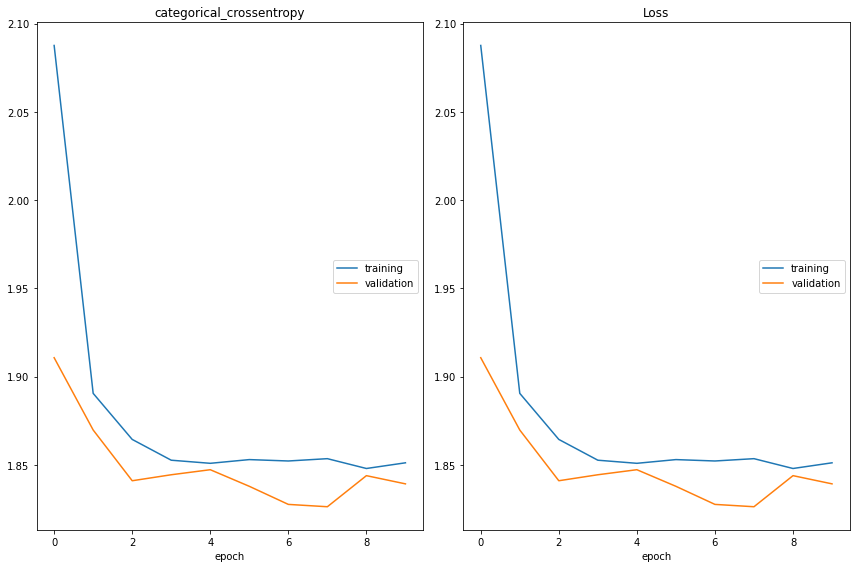

categorical_crossentropy
	training         	 (min:    1.848, max:    2.088, cur:    1.851)
	validation       	 (min:    1.826, max:    1.911, cur:    1.839)
Loss
	training         	 (min:    1.848, max:    2.088, cur:    1.851)
	validation       	 (min:    1.826, max:    1.911, cur:    1.839)
9/9 [==============================] - 5s 529ms/step - loss: 1.8512 - categorical_crossentropy: 1.8512 - val_loss: 1.8393 - val_categorical_crossentropy: 1.8393


In [17]:
model.fit(x_train,y_train,epochs=10,batch_size=64,validation_split=0.2,callbacks=callback)

In [18]:
test_x = x_test[11:]
test_x.shape
model = tf.keras.models.load_model('model_weights.h5')
probas = model.predict(test_x)
pred_indices = np.argmax(probas,axis=1)
classes = np.array(range(1,10))
print('Log loss: {}'.format(log_loss(classes[np.argmax(y_test, axis=1)], probas)))

Log loss: 1.84102774365504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


-------------------- Confusion matrix --------------------


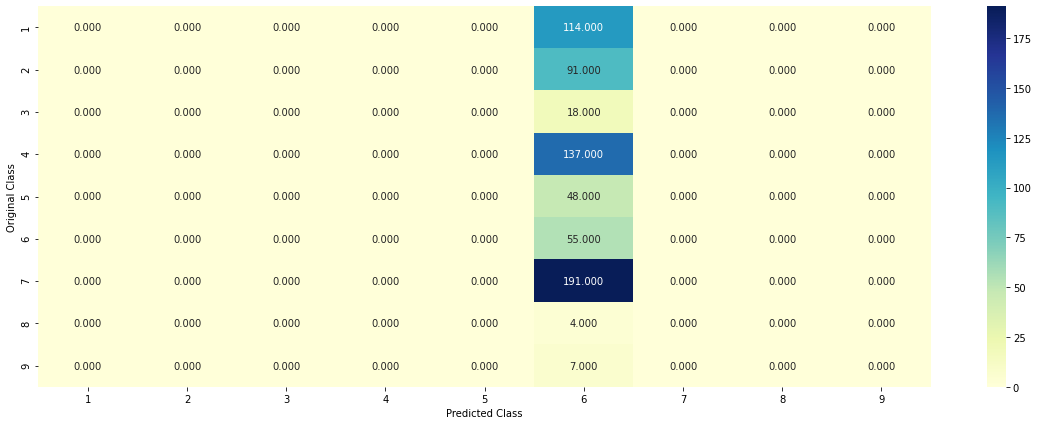

-------------------- Precision matrix (Columm Sum=1) --------------------


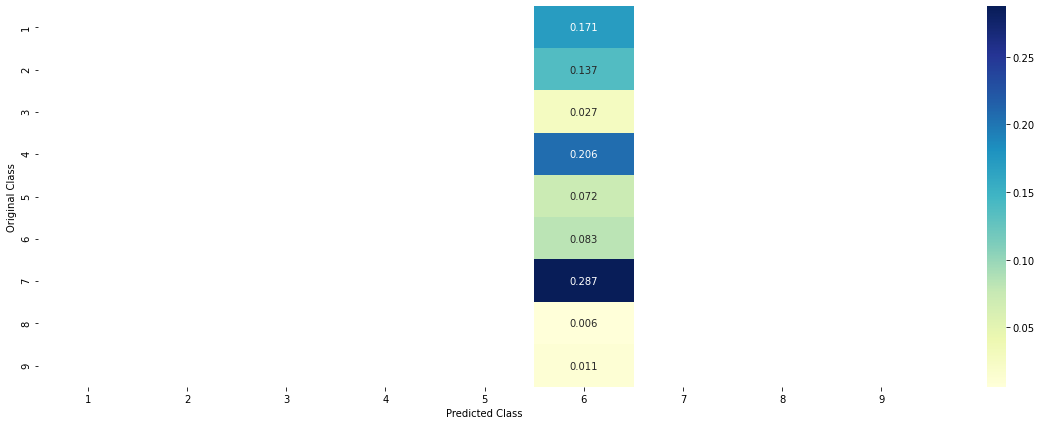

-------------------- Recall matrix (Row sum=1) --------------------


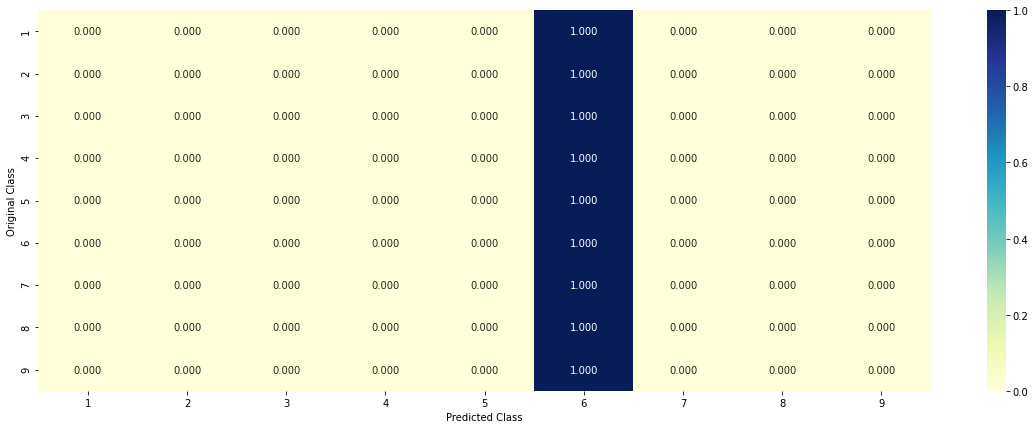

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


In [19]:
plot_confusion_matrix((classes[np.argmax(y_test, axis=1)]),pred_indices)